In [4]:
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns

from matplotlib import pyplot as plt
import warnings
import numpy as np
import datetime
warnings.filterwarnings('ignore')

In [33]:
parquetDf = pq.ParquetDataset('../Data/train_subsession_dateData.parquet')
eventsDf = parquetDf.read().to_pandas()

Explore sample data
We will sample randomly 1M rows and look at different areas.

In [11]:
sampleEventsDf = eventsDf.head(n=1000000)
sampleEventsDf.reset_index(inplace=True)

In [12]:
nEvents = len(sampleEventsDf)
actionFreq = ((sampleEventsDf.groupby(['type']).size() / nEvents) * 100).round(2)
print(actionFreq)

type
carts      7.10
clicks    91.04
orders     1.86
dtype: float64


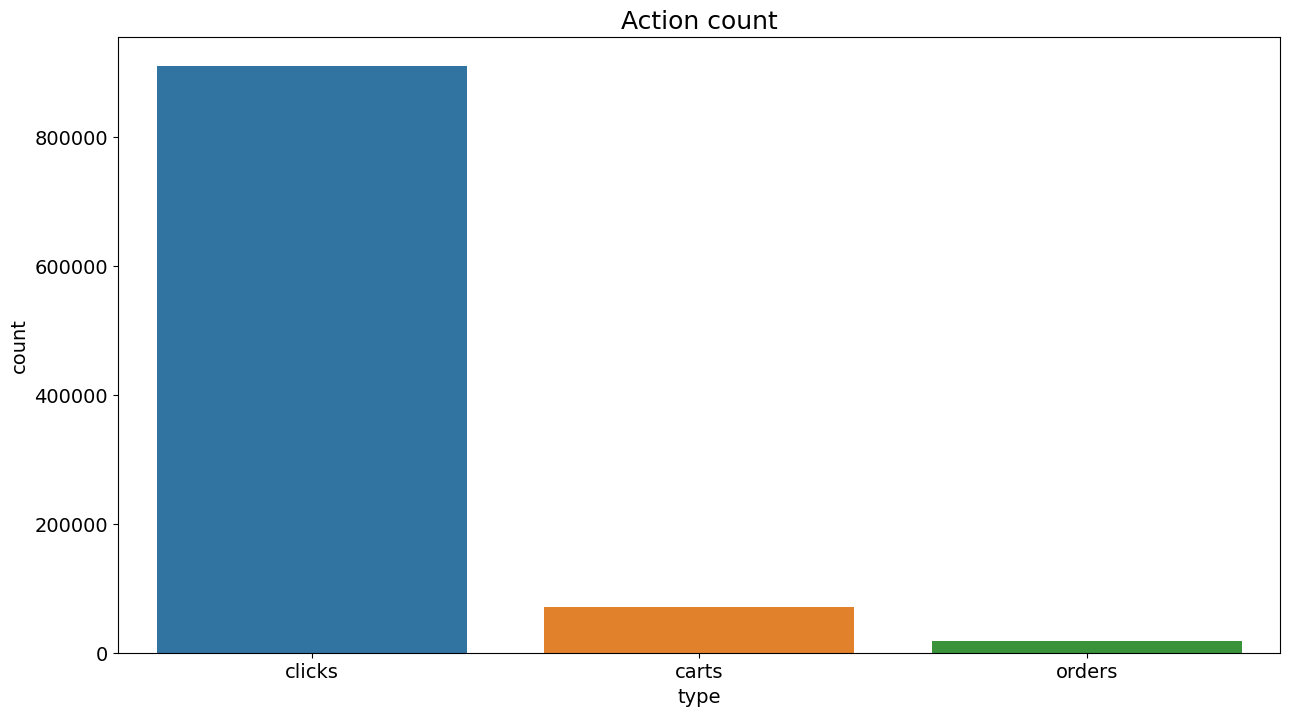

In [13]:
plt.figure(figsize=(15,8))
plt.title('Action count',fontsize=18)
b = sns.countplot(x=sampleEventsDf['type'])
b.set_xlabel('type',fontsize=14)
b.set_ylabel('count',fontsize=14)
b.tick_params(labelsize=14)


In [15]:
#Distribution of number of actions performed in events

listofactions = [i for i in sampleEventsDf.groupby(['sessionId']).size()]
pd.Series(listofactions).describe().round()

count    17371.0
mean        58.0
std         82.0
min          2.0
25%          7.0
50%         22.0
75%         72.0
max        495.0
dtype: float64

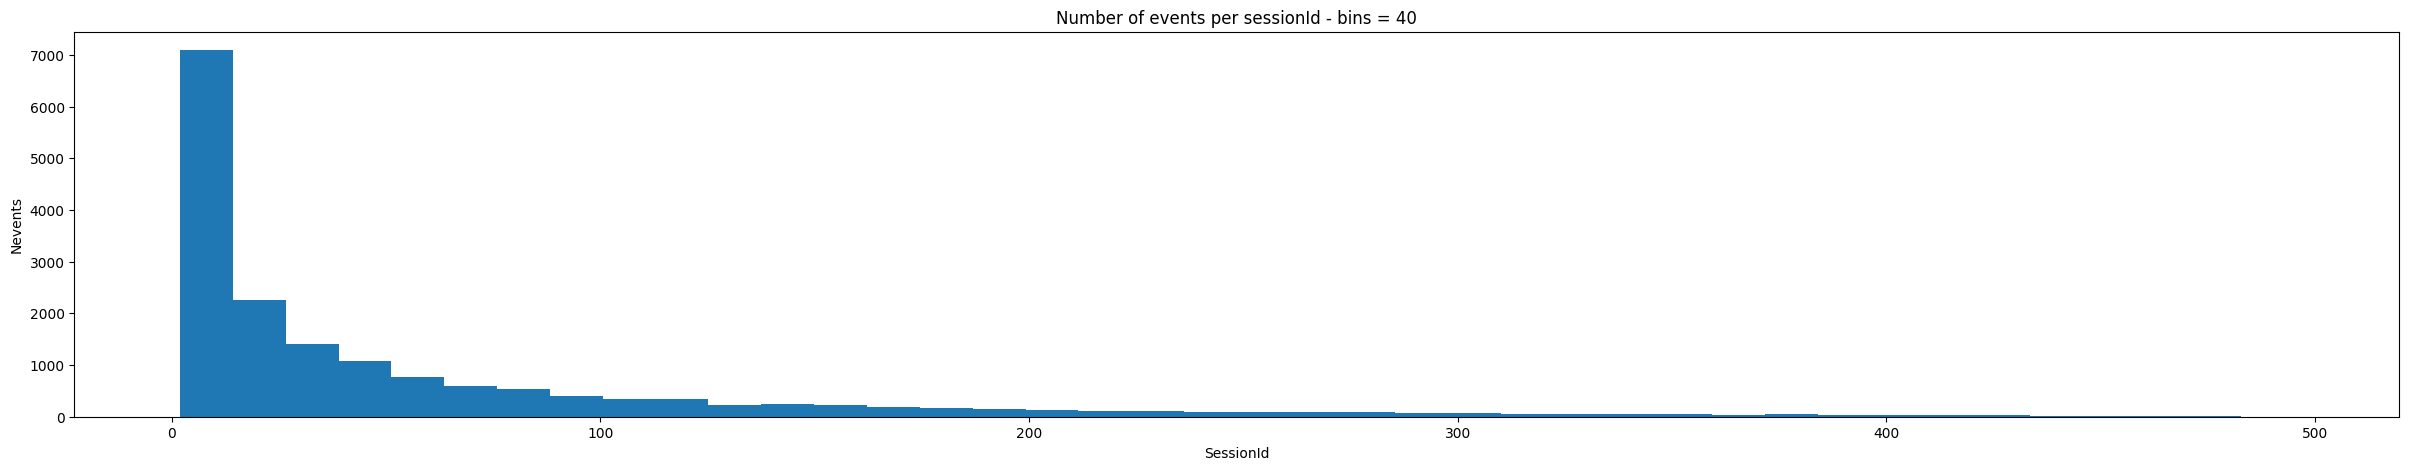

In [23]:
nbins=40
plt.figure(figsize=(30,5))
plt.hist(listofactions,nbins)
plt.title(f"Number of events per sessionId - bins = {nbins}")
plt.xlabel("SessionId")
plt.ylabel("Nevents")
plt.show()

Insights:

* Range of events per session = [2 , 495]
* mean is at 58 actions
* standar deviation is at 82 actions.

* carts      7.10 %
* clicks    91.04 %
* orders     1.86 %

FEATURE ENGINEERING

* Creating Subsessions --> based on sessionId & cut difference
* Creating date columns --> dayofweek, month, year, day..


In [27]:
#Create subsessions with 2 hours interval.
sampleEventsDf.sort_values(by=['sessionId','ts'])
timeDeltas = [(sampleEventsDf[sampleEventsDf['sessionId']==session]['ts'] - np.insert(sampleEventsDf[sampleEventsDf['sessionId']==session]['ts'].values,0,0,axis=0)[:-1]).values for session in pd.unique(sampleEventsDf['sessionId'])]
timeDeltas = [item for sublist in timeDeltas for item in sublist]
sampleEventsDf['dif'] = timeDeltas
cut_dif = pd.Timedelta(2,'h')
i=0
l=[]

for sessionId in pd.unique(sampleEventsDf['sessionId']):
    for event in sampleEventsDf[sampleEventsDf['sessionId'] == sessionId].values:
        if event[-1]>cut_dif:
            i=i+1
        l.append(i)


sampleEventsDf['subsession'] = l


#Create date features
sampleEventsDf.loc[:, 'month'] = sampleEventsDf['ts'].dt.month
sampleEventsDf.loc[:, 'weekofyear'] = sampleEventsDf['ts'].dt.weekofyear
sampleEventsDf.loc[:, 'dayofweek'] = sampleEventsDf['ts'].dt.dayofweek


In [32]:
sampleEventsDf.head()
sampleEventsDf.to_parquet("../Data/train_subsession_dateData.parquet")

In [29]:
#create sessionId and event counts. Replace NaN with 0
user_counts = sampleEventsDf.groupby(['sessionId','type']).count()['ts'].unstack(level=-1).fillna(0)
user_counts

type,carts,clicks,orders
sessionId,,,
0,17.0,255.0,4.0
1,8.0,24.0,0.0
2,1.0,32.0,0.0
3,21.0,200.0,5.0
4,3.0,15.0,1.0
...,...,...,...
17366,0.0,7.0,0.0
17367,0.0,4.0,0.0
17368,0.0,67.0,0.0


In [30]:
#create product Id and event counts. Replace NaN with 0
product_counts = sampleEventsDf.groupby(['aid','type']).count()['ts'].unstack(level=-1).fillna(0)
#create percentages of each column for each aid:
product_counts['%click'] = (product_counts['clicks']/product_counts['clicks'].sum())*100
product_counts['%cart'] = (product_counts['carts']/product_counts['carts'].sum())*100
product_counts['%order'] = (product_counts['orders']/product_counts['orders'].sum())*100

product_counts

type,carts,clicks,orders,%click,%cart,%order
aid,,,,,,
1,0.0,1.0,0.0,0.000110,0.000000,0.0
3,0.0,1.0,0.0,0.000110,0.000000,0.0
4,0.0,3.0,0.0,0.000330,0.000000,0.0
22,0.0,1.0,0.0,0.000110,0.000000,0.0
38,0.0,12.0,0.0,0.001318,0.000000,0.0
...,...,...,...,...,...,...
1855582,0.0,1.0,0.0,0.000110,0.000000,0.0
1855584,0.0,1.0,0.0,0.000110,0.000000,0.0
1855594,1.0,2.0,0.0,0.000220,0.001409,0.0


In [31]:
subs_counts = sampleEventsDf.groupby(['subsession','type']).count()['ts'].unstack(level=-1).fillna(0)
subs_counts

type,carts,clicks,orders
subsession,,,
1,0.0,2.0,0.0
2,2.0,16.0,2.0
3,0.0,8.0,0.0
4,0.0,1.0,0.0
5,0.0,11.0,0.0
...,...,...,...
158811,0.0,2.0,0.0
158812,0.0,2.0,0.0
158813,0.0,1.0,0.0


In [34]:
#From here i am using the original dataset with subsession and date data added
sampleEventsDf.head()

,ts,sessionId,aid,type,dif,subsession,month,weekofyear,dayofweek
0,2022-07-31 22:00:00.025,0,1517085,clicks,19204 days 22:00:00.025000,1,7,30,6
1,2022-07-31 22:01:44.511,0,1563459,clicks,0 days 00:01:44.486000,1,7,30,6
2,2022-08-01 15:23:59.426,0,1309446,clicks,0 days 17:22:14.915000,2,8,31,0
3,2022-08-01 15:28:39.997,0,16246,clicks,0 days 00:04:40.571000,2,8,31,0
4,2022-08-01 15:31:11.344,0,1781822,clicks,0 days 00:02:31.347000,2,8,31,0
